<a href="https://colab.research.google.com/github/ArtemBurenok/theory_of_prediction/blob/main/theory_of_prediction_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/ls_variants.xls', sheet_name='вар. 3')
x_array_single, y_array = np.array(data['x']), np.array(data['y'])

In [ ]:
x_sixth = np.c_[x_array_single, x_array_single ** 2, x_array_single ** 3, x_array_single ** 4, x_array_single ** 5, x_array_single ** 6, x_array_single ** 7, x_array_single ** 8, x_array_single ** 9, x_array_single ** 10]

In [ ]:
def normal_solution(X, y):
    x_adv = np.c_[X, np.ones((X.shape[0], 1))]
    return np.linalg.inv(x_adv.T.dot(x_adv)).dot(x_adv.T).dot(y)

In [ ]:
beta = normal_solution(x_sixth, np.array(data['y']))

In [ ]:
reminds = np.array(data['y']) - np.c_[x_sixth, np.ones((x_sixth.shape[0], 1))].dot(beta)

## 1. Для проверки постоянства математического ожидания

График остатков

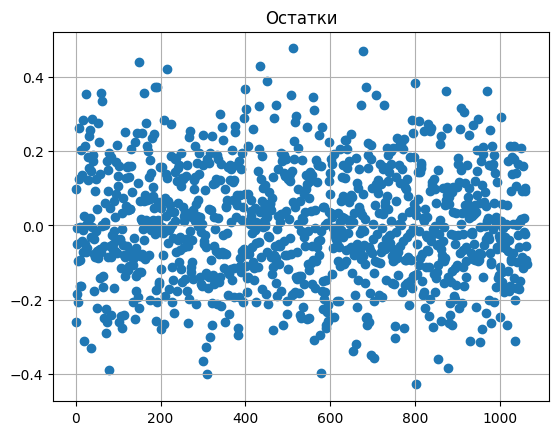

In [ ]:
plt.title('Остатки')
# plt.scatter(range(data['y'].shape[0]), np.array(data['y']) - np.c_[x_sixth, np.ones((x_sixth.shape[0], 1))].dot(beta))
plt.scatter(range(data['y'].shape[0]), reminds)
plt.grid()
plt.show()

Дисперсионный анализ ошибок

In [ ]:
def variance_analysis(reminds, boundary: list):
    groups = np.split(reminds, boundary)
    mean_group = list()
    mean_for_all = np.mean(reminds)

    for group in groups:
        mean_group.append(np.mean(group))

    size_groups = [group.shape[0] for group in groups]

    S_0 = np.sum([size_group * (mean_g - mean_for_all) ** 2 for size_group, mean_g in zip(size_groups, mean_group)])
    S = np.sum((reminds - mean_for_all) ** 2)

    compute_statistic = S_0 * (reminds.shape[0] - len(groups)) / (S * ( len(groups) - 1))

    critical_value = stats.f.ppf(q=1-0.05, dfn=reminds.shape[0] - len(groups), dfd=len(groups) - 1)

    return compute_statistic, critical_value

In [ ]:
result = variance_analysis(np.array(data['y']) - np.c_[x_sixth, np.ones((x_sixth.shape[0], 1))].dot(beta), [100, 200, 350, 550, 750, 900, 1000])

In [ ]:
result

(0.7196759128927045, 3.2340769572470283)

In [ ]:
print('Средние равны') if result[0] < result[1] else print('Средние не равны')

Средние равны


## 2. Для проверки постоянства дисперсии

График остатков

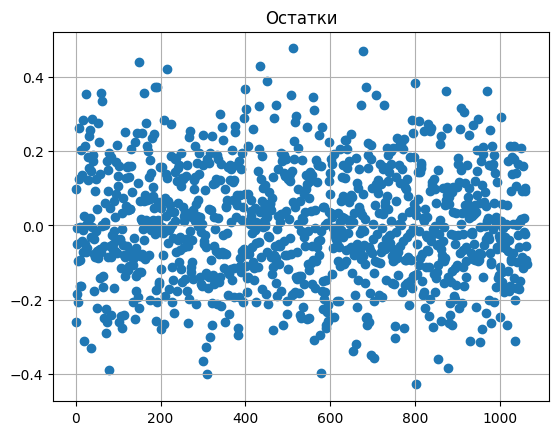

In [ ]:
plt.title('Остатки')
plt.scatter(range(data['y'].shape[0]), np.array(data['y']) - np.c_[x_sixth, np.ones((x_sixth.shape[0], 1))].dot(beta))
plt.grid()
plt.show()

Критерий Уайта

In [ ]:
def white_test(X, reminds):
    X_new = np.c_[X, X**2, X**3,np.ones((X.shape[0], 1))]
    beta_list = np.linalg.inv(X_new.T.dot(X_new)).dot(X_new.T).dot(reminds)

    y_regression = X_new.dot(np.array(beta_list))

    sum_reminder = np.sum([(y - y_r) ** 2 for y, y_r in zip(reminds, y_regression)])
    sum_full = np.sum((reminds - np.mean(reminds)) ** 2)

    R_square = 1 - sum_reminder / sum_full

    critical_value = stats.chi2.ppf(1-.05, X_new.shape[1] -1)

    return R_square * X.shape[0], critical_value

In [ ]:
white_test(np.array(data['x']), np.array(data['y']) - np.c_[x_sixth, np.ones((x_sixth.shape[0], 1))].dot(beta))

(1.212758307699774, 7.814727903251179)

In [ ]:
result = white_test(np.array(data['x']), np.array(data['y']) - np.c_[x_sixth, np.ones((x_sixth.shape[0], 1))].dot(beta))
print("Дисперсия постоянна") if result[0] < result[1] else print("Дисперсия не постоянна")

Дисперсия постоянна


Критерий Голфелда-Квандта

In [ ]:
def golfeld_quandt(X, y):
    groups_X = np.split(X, [X.shape[0] // 3, 2 * X.shape[0] // 3])
    groups_y = np.split(y, [y.shape[0] // 3, 2 * y.shape[0] // 3])

    model_first = LinearRegression()
    model_first.fit(np.array(groups_X[0]).reshape(-1, 1), groups_y[0])

    model_last = LinearRegression()
    model_last.fit(np.array(groups_X[len(groups_X) - 1]).reshape(-1, 1), groups_y[len(groups_y) - 1])

    prediction_0 = model_first.coef_[0] * np.array(groups_X[0]) + model_first.intercept_
    S_0 = np.sum((groups_y[0] - prediction_0) ** 2)

    prediction_2 = model_last.coef_[0] * np.array(groups_X[len(groups_X) - 1]) + model_last.intercept_
    S_2 = np.sum((groups_y[len(groups_X) - 1] - prediction_2) ** 2)

    critical_value = stats.f.ppf(q=1-0.05, dfn=groups_y[0].shape[0] - 2, dfd=groups_y[len(groups_y) - 1].shape[0] - 2)

    return S_0 * (groups_y[len(groups_y) - 1].shape[0] - 2) / (S_2 * (groups_y[0].shape[0] - 2)), critical_value

In [ ]:
golfeld_quandt(data['x'], reminds)

(1.1154834131779463, 1.1917724731837829)

In [ ]:
result = golfeld_quandt(data['x'], reminds)
print("Дисперсия постоянна") if result[0] < result[1] else print("Дисперсия не постоянна")

Дисперсия постоянна


## 3. Для проверки отсутствия автокорреляции

Коррелограмма – график автокорреляционной функции

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

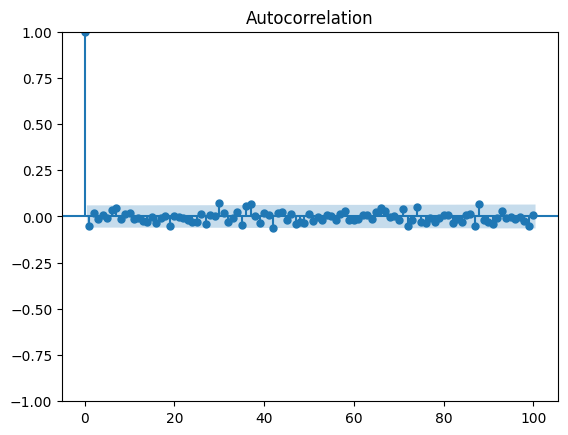

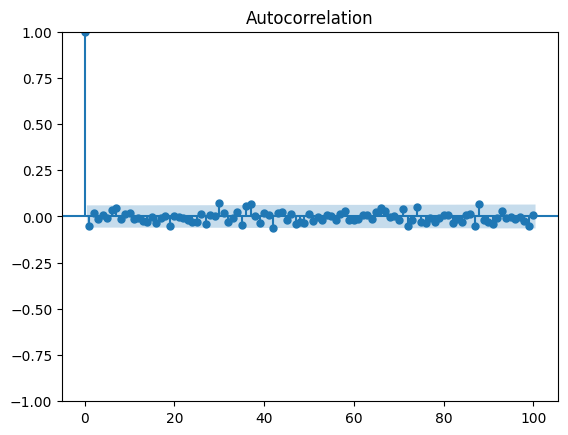

In [ ]:
plot_acf(reminds, lags=100)

Q-критерий Льюнга-Бокса (остатки не являются независимы)

In [ ]:
import statsmodels.api as sm

In [ ]:
result = sm.stats.acorr_ljungbox(reminds, lags=[50, 100], model_df=8)

In [ ]:
result_list = []
for number in [10, 15, 20]:
    result_list.append(np.float32(sm.stats.acorr_ljungbox(reminds, lags=[number], model_df=number - x_sixth.shape[1])['lb_pvalue'])[0])

In [ ]:
result_list

[0.6773934, 0.51407534, 0.19421002]

In [ ]:
for i in result_list:
    print('Остатки не распределяются независимо (имеют серийную корреляцию)') if i < 0.05 else print('Остатки распределяются независимо')

Остатки распределяются независимо
Остатки распределяются независимо
Остатки распределяются независимо


## 4. Для проверки согласия с нормальным распределением

гистограмма + график плотности

In [ ]:
from scipy.stats import norm
import seaborn as sns

<ipython-input-68-8fc3b737fdc0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reminds, hist=True, kde=True,


<Axes: ylabel='Density'>

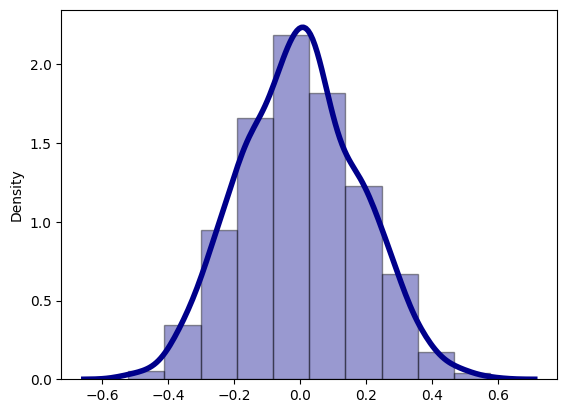

In [ ]:
sns.distplot(reminds, hist=True, kde=True,
             bins=10, color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
def draw_hist(data):
    mean, std = np.mean(data), np.std(data)
    plt.hist(data, bins=30, density=True, alpha=0.6, color='b')

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std)

    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

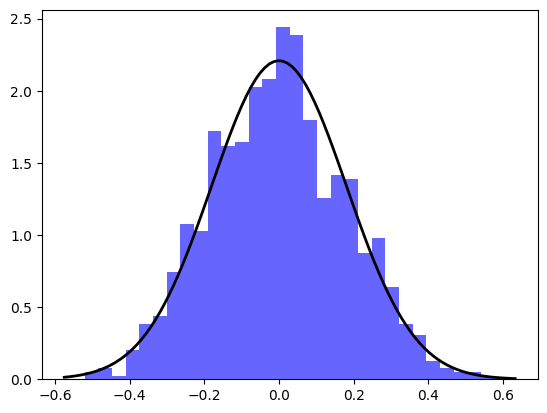

In [ ]:
draw_hist(reminds)

In [ ]:
np.mean(reminds), np.std(reminds)

(-0.00014307516271057437, 0.18062894032015683)

Вероятностная бумага

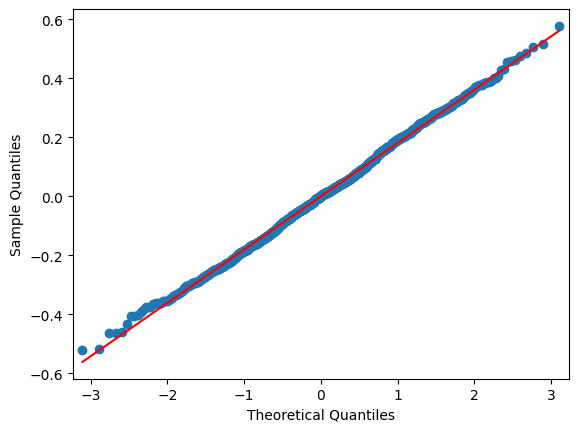

In [ ]:
sm.qqplot(reminds, line='s')
plt.show()

Хи-квадрат

In [ ]:
reminds_norm = (reminds - np.mean(reminds)) / np.std(reminds)

In [ ]:
count_bins = int(1+np.log2(reminds_norm.shape[0]))
interval = np.linspace(-0.6, 0.6, count_bins)
interval = np.append(interval, np.inf)
count_bins += 1

bins_count, _ = np.histogram(reminds_norm, bins=interval)

In [ ]:
expected_counts = []

for i in range(count_bins - 1):
    expected_counts.append((stats.norm.cdf(interval[i+1], loc=np.mean(reminds_norm), scale=np.std(reminds_norm)) - stats.norm.cdf(interval[i], loc=np.mean(reminds_norm), scale=np.std(reminds_norm))) * reminds_norm.shape[0])

In [ ]:
chi_square = sum((observer - expected) ** 2 / expected for observer, expected in zip(bins_count, expected_counts))

In [ ]:
dof = count_bins - 2 - x_sixth.shape[1]
alpha = 0.05
chi_square_crit = stats.chi2.ppf(1-alpha, dof)

In [ ]:
print('Распределение является нормальным') if chi_square > chi_square_crit else print('Распределение не является нормальным')

Распределение является нормальным
